# Single-Cell Gene Expression

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("..")

In [2]:
dir = '../figs/singlecell/'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scprep
import numpy as np
import pandas as pd
from sklearn.utils.extmath import randomized_svd

In [4]:
def mse(x, y):
    return ((x - y)**2).mean()
def norm(x):
    return (x**2).mean()

In [6]:
data_raw = scprep.io.load_csv('https://github.com/KrishnaswamyLab/PHATE/raw/master/data/BMMC_myeloid.csv.gz')
#data_raw.to_pickle('data/BMMC_myeloid.gzip')
#data_raw = pd.read_pickle('data/BMMC_myeloid.gzip')

In [7]:
data_raw.shape

(2730, 27297)

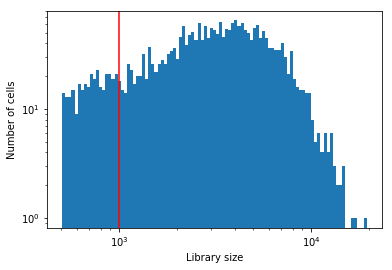

In [8]:
scprep.plot.plot_library_size(data_raw, cutoff=1000)

In [9]:
data_raw = scprep.filter.filter_library_size(data_raw, cutoff=1000)
data_raw = scprep.filter.remove_rare_genes(data_raw, min_cells=10)

In [10]:
data_raw.shape

(2416, 10782)

In [11]:
data = scprep.normalize.library_size_normalize(data_raw)
data = scprep.transform.sqrt(data)

In [12]:
# Input p is percent to set aside for validation

def split_data(df, p):
    X_target = np.random.binomial(df.values, p)
    X_masked = df.values - X_target
    df_masked = pd.DataFrame(data = X_masked,
                                 index = df.index,
                                 columns = df.columns)
    df_target = pd.DataFrame(data = X_target,
                                 index = df.index,
                                 columns = df.columns)
    return df_masked, df_target

data_masked, data_target = split_data(data_raw, 0.5)

data_masked = scprep.normalize.library_size_normalize(data_masked)
#data_masked = scprep.transform.log(data_masked)
data_masked = scprep.transform.sqrt(data_masked)

data_target = scprep.normalize.library_size_normalize(data_target)
#data_target = scprep.transform.log(data_masked)
data_target = scprep.transform.sqrt(data_target)

In [13]:
X1 = data_masked.values
X2 = data_target.values

In [14]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, X2)

In [16]:
U, S, V = randomized_svd(X_train, n_components = 100)

In [17]:
mses = []
rank_range = range(6, 30)
for k in rank_range:
    prediction = X_test.dot(V[:k,:].T.dot(np.diag(1/S[:k]).dot(U[:,:k].T).dot(Y_train)))
    current_mse = mse(prediction, Y_test)
    mses.append(current_mse)

In [18]:
opt = rank_range[np.argmin(mses)]
opt

17

Text(0,0.5,'N2S Loss')

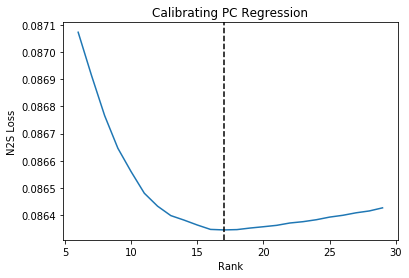

In [19]:
plt.plot(rank_range, mses)
plt.axvline(opt, color='k', linestyle='--')
plt.title("Calibrating PC Regression")
plt.xlabel("Rank")
plt.ylabel("N2S Loss")

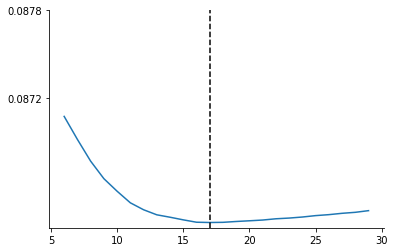

In [20]:
plt.plot(rank_range, mses)
plt.axvline(opt, color='k', linestyle='--')


plt.yticks([0.0872, 0.0878])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.savefig(dir + 'pc_regression.pdf')

In [21]:
k = opt
U, S, V = randomized_svd(X1, n_components = 100)
prediction = X1.dot(V[:k,:].T.dot(np.diag(1/S[:k]).dot(U[:,:k].T).dot(X2)))

In [22]:
reconstructed_data = pd.DataFrame(prediction, index = data.index, columns=data.columns)

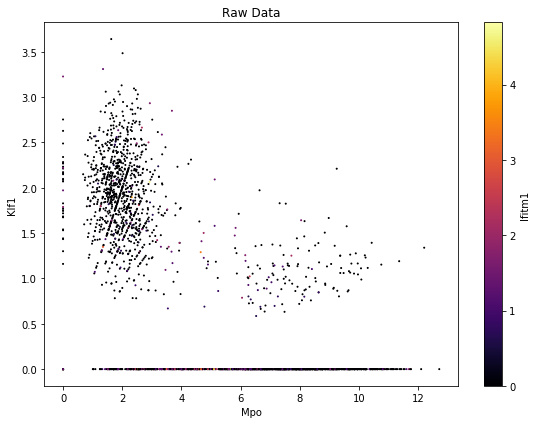

In [23]:
plt.figure(figsize=(8,6))

plt.scatter(data['Mpo'], data['Klf1'], c=data['Ifitm1'], cmap='inferno', s=1)
plt.xlabel('Mpo')
plt.ylabel('Klf1')
plt.title('Raw Data')

plt.colorbar(label='Ifitm1')

plt.tight_layout()
# plt.savefig(dir + 'raw_data_with_labels.pdf')

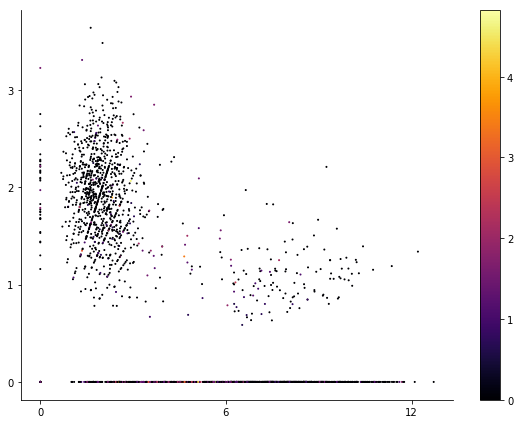

In [24]:
plt.figure(figsize=(8,6))

plt.scatter(data['Mpo'], data['Klf1'], c=data['Ifitm1'], cmap='inferno', s=1)
plt.colorbar()

plt.yticks([0.0, 1.0, 2.0, 3.0])
plt.xticks([0, 6, 12])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()

# plt.savefig(dir + 'raw_data_with_colorbar.pdf')

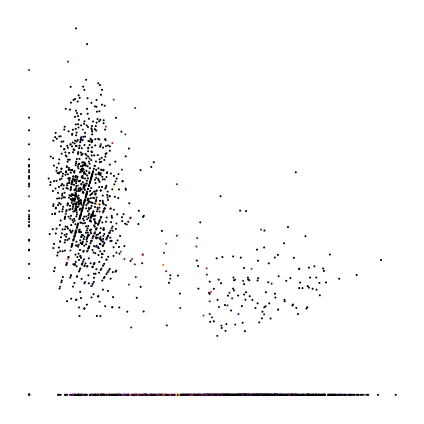

In [25]:
plt.figure(figsize=(6,6))

plt.scatter(data['Mpo'], data['Klf1'], c=data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([])
plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()

# plt.savefig(dir + 'raw_data_noaxis.png')

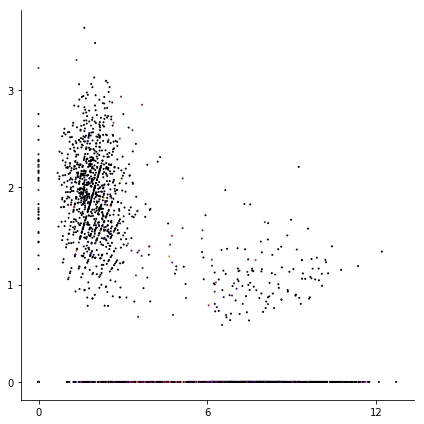

In [26]:
plt.figure(figsize=(6,6))

plt.scatter(data['Mpo'], data['Klf1'], c=data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([0.0, 1.0, 2.0, 3.0])
plt.xticks([0, 6, 12])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()

# plt.savefig(dir + 'raw_data.png')

In [27]:
U, S, V = randomized_svd(X1, n_components = 200)

In [28]:
k = 17
prediction = X1.dot(V[:k,:].T.dot(np.diag(1/S[:k]).dot(U[:,:k].T).dot(X2)))
reconstructed_data = pd.DataFrame(prediction, index = data.index, columns=data.columns)

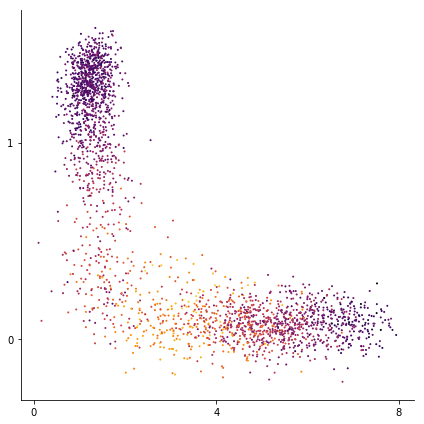

In [29]:
plt.figure(figsize=(6,6))

plt.scatter(reconstructed_data['Mpo'], reconstructed_data['Klf1'], c=reconstructed_data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([0.0, 1.0])
plt.xticks([0, 4, 8])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()

# plt.savefig(dir + 'denoised_data.pdf')

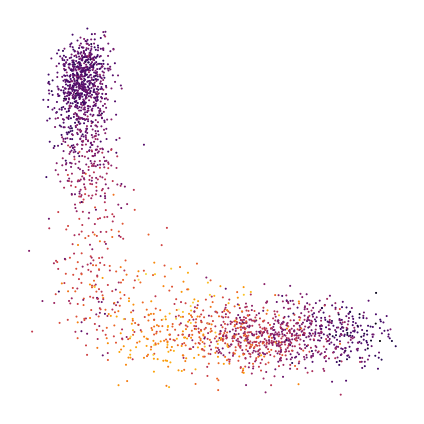

In [30]:
plt.figure(figsize=(6,6))

plt.scatter(reconstructed_data['Mpo'], reconstructed_data['Klf1'], c=reconstructed_data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([])
plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()

# plt.savefig(dir + 'denoised_data_noaxis.pdf')

In [31]:
k = 3
prediction = X1.dot(V[:k,:].T.dot(np.diag(1/S[:k]).dot(U[:,:k].T).dot(X2)))
reconstructed_data = pd.DataFrame(prediction, index = data.index, columns=data.columns)

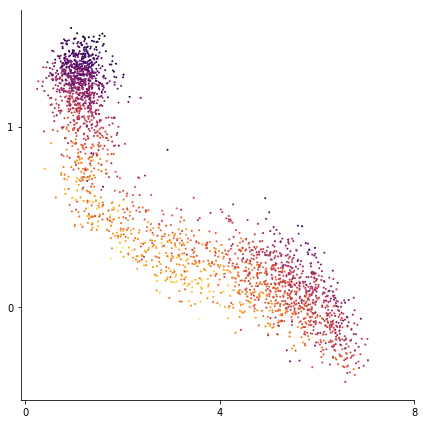

In [32]:
plt.figure(figsize=(6,6))

plt.scatter(reconstructed_data['Mpo'], reconstructed_data['Klf1'], c=reconstructed_data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([0.0, 1.0])
plt.xticks([0, 4, 8])

plt.tight_layout()

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.savefig(dir + 'under_corrected_data.pdf')

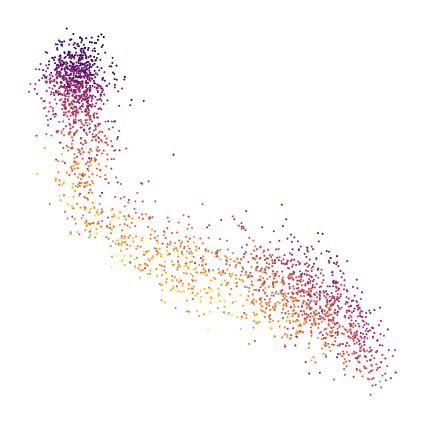

In [33]:
plt.figure(figsize=(6,6))

plt.scatter(reconstructed_data['Mpo'], reconstructed_data['Klf1'], c=reconstructed_data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([])
plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.savefig(dir + 'under_corrected_data_noaxis.pdf')

In [34]:
k = 300
prediction = X1.dot(V[:k,:].T.dot(np.diag(1/S[:k]).dot(U[:,:k].T).dot(X2)))
reconstructed_data = pd.DataFrame(prediction, index = data.index, columns=data.columns)

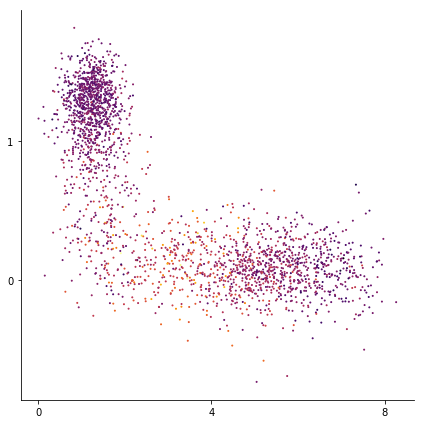

In [35]:
plt.figure(figsize=(6,6))

plt.scatter(reconstructed_data['Mpo'], reconstructed_data['Klf1'], c=reconstructed_data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([0.0, 1.0])
plt.xticks([0, 4, 8])

plt.tight_layout()

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.savefig(dir + 'overcorrected_data.pdf')

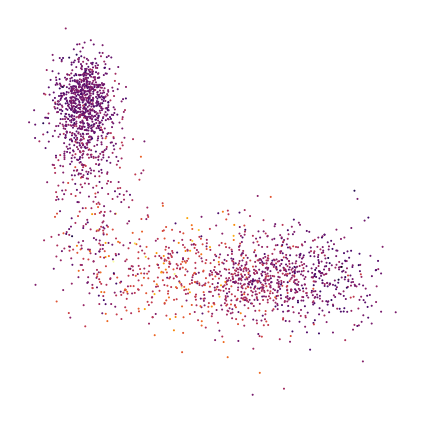

In [36]:
plt.figure(figsize=(6,6))

plt.scatter(reconstructed_data['Mpo'], reconstructed_data['Klf1'], c=reconstructed_data['Ifitm1'], cmap='inferno', s=1)

plt.yticks([])
plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


plt.tight_layout()

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.savefig(dir + 'overcorrected_data_noaxis.pdf')